In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv
from sklearn.preprocessing import LabelEncoder
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import cv2
import math
import pickle
from sklearn.datasets import load_wine
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from more_itertools import powerset
from sklearn.metrics import accuracy_score, hamming_loss
import wandb
label_encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

In [2]:
data = pd.read_csv('./advertisement.csv')
data = data.drop('city', axis=1)
print(data)

     age  gender        income    education  married  children   occupation   
0     45    Male  61271.953359       Master    False         3       Doctor  \
1     24  Female  53229.101074  High School    False         1  Businessman   
2     45  Female  30066.046684     Bachelor     True         3     Engineer   
3     19    Male  48950.246384          PhD    False         0       Lawyer   
4     29  Female  44792.627094       Master    False         0  Businessman   
..   ...     ...           ...          ...      ...       ...          ...   
995   61    Male  34246.773063       Master     True         3           HR   
996   56  Female  45494.225591     Bachelor    False         0     Engineer   
997   64  Female  68740.442006          PhD     True         0     Salesman   
998   18  Female  44348.446680     Bachelor     True         0      Retired   
999   61    Male  39160.083677       Master    False         0    Housewife   

     purchase_amount most bought item              

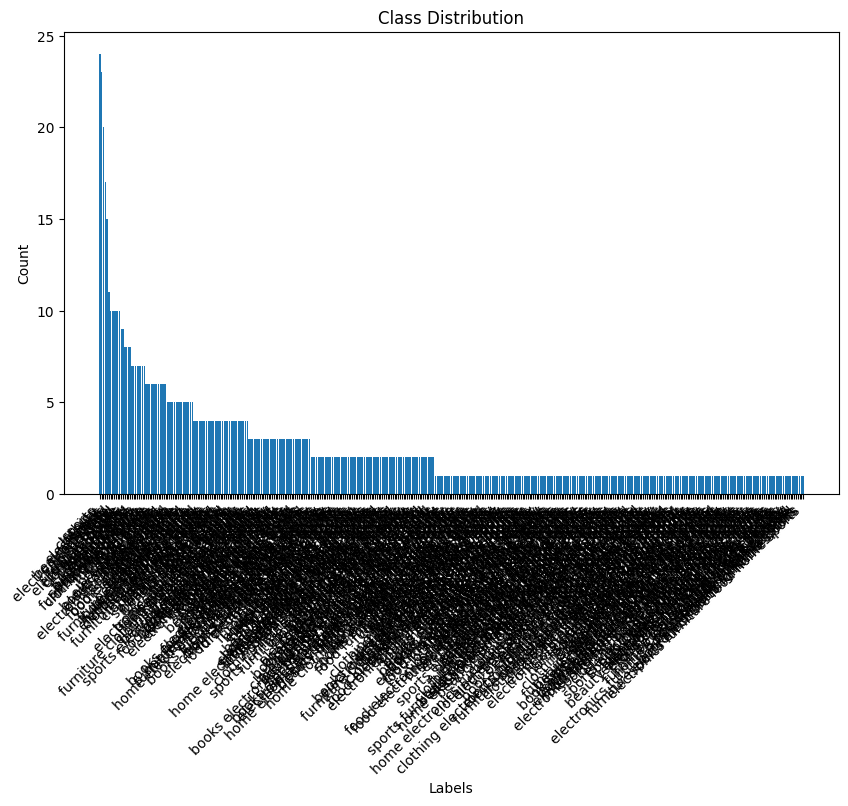

In [3]:
class_counts = data['labels'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

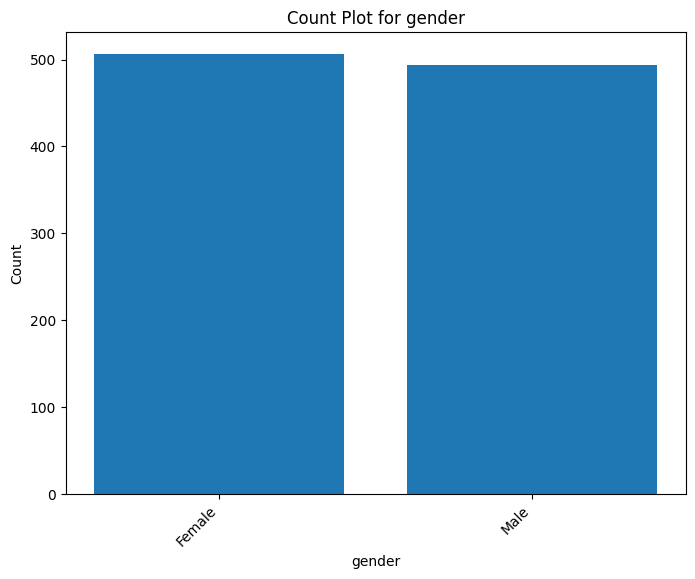

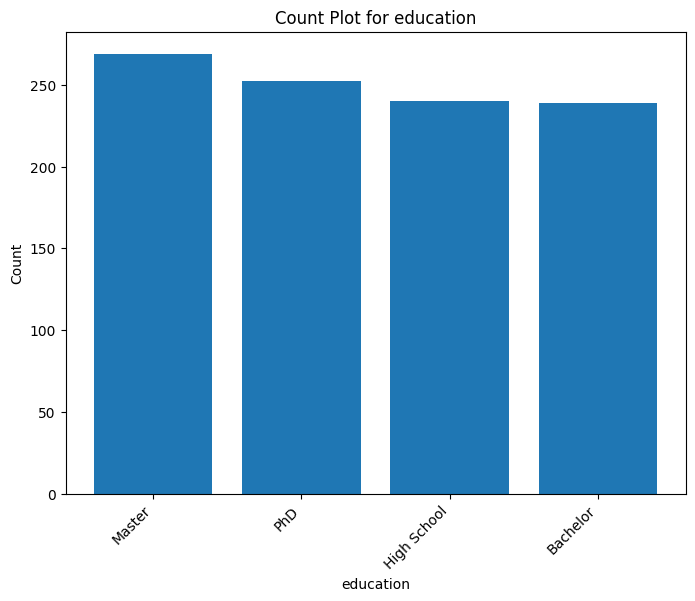

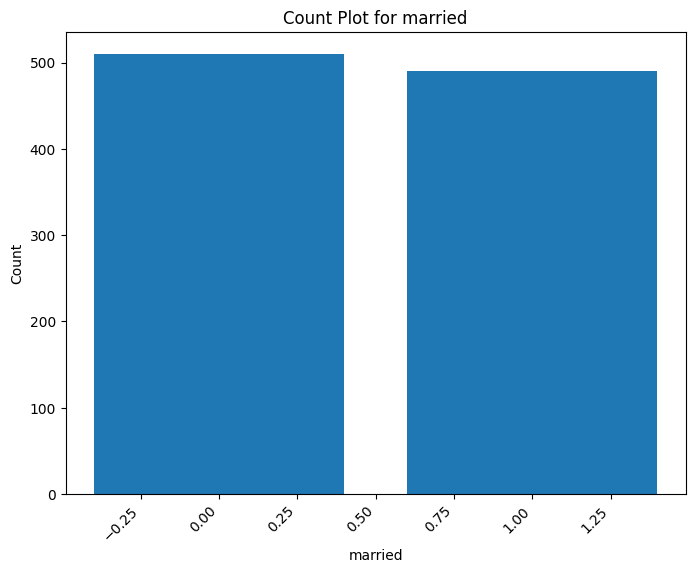

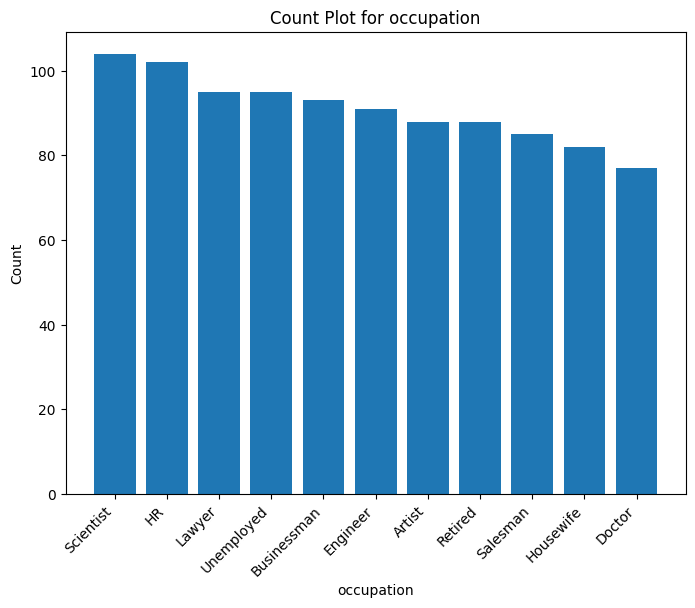

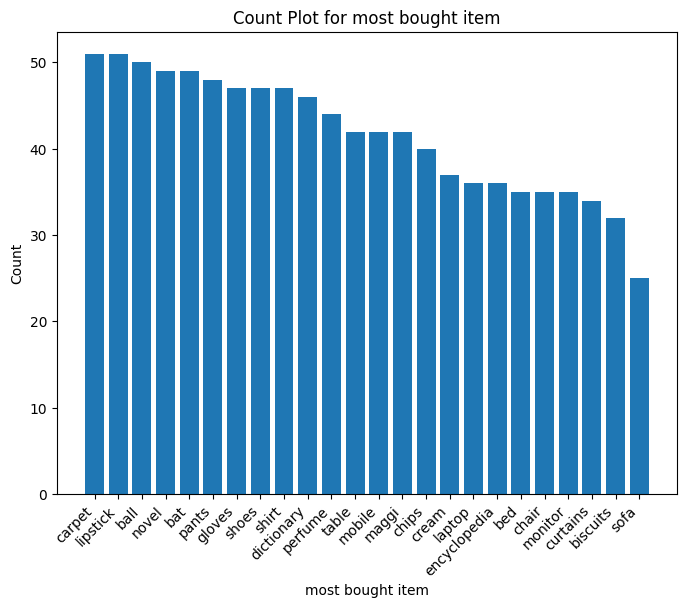

In [4]:
categorical_vars = ["gender", "education", "married", "occupation", "most bought item"]
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    counts = data[var].value_counts()
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(var)
    plt.ylabel("Count")
    plt.title(f"Count Plot for {var}")
    plt.show()

In [5]:
list_of_labels = [text.split() for text in data['labels']]
flat_list = [item for sublist in list_of_labels for item in sublist]
unique_elements = set(flat_list)
print(unique_elements)
power_set = list(powerset(unique_elements))
power_set.pop(0)
power_set = [tuple(sorted(t)) for t in power_set]
print((power_set))
binary_representation = []
for tup in power_set:
    binary = [0] * len(unique_elements)
    for i, element in enumerate(unique_elements):
        if element in tup:
            binary[i] = 1
    binary_representation.append(binary)
print(binary_representation)

{'food', 'books', 'electronics', 'clothing', 'furniture', 'beauty', 'sports', 'home'}
[('food',), ('books',), ('electronics',), ('clothing',), ('furniture',), ('beauty',), ('sports',), ('home',), ('books', 'food'), ('electronics', 'food'), ('clothing', 'food'), ('food', 'furniture'), ('beauty', 'food'), ('food', 'sports'), ('food', 'home'), ('books', 'electronics'), ('books', 'clothing'), ('books', 'furniture'), ('beauty', 'books'), ('books', 'sports'), ('books', 'home'), ('clothing', 'electronics'), ('electronics', 'furniture'), ('beauty', 'electronics'), ('electronics', 'sports'), ('electronics', 'home'), ('clothing', 'furniture'), ('beauty', 'clothing'), ('clothing', 'sports'), ('clothing', 'home'), ('beauty', 'furniture'), ('furniture', 'sports'), ('furniture', 'home'), ('beauty', 'sports'), ('beauty', 'home'), ('home', 'sports'), ('books', 'electronics', 'food'), ('books', 'clothing', 'food'), ('books', 'food', 'furniture'), ('beauty', 'books', 'food'), ('books', 'food', 'sports')

In [6]:
data['labels'] = data['labels'].str.split()
data['labels'] = data['labels'].apply(lambda x: tuple(x))
data['labels'] = data['labels'].apply(lambda x: tuple(sorted(x)))
print(data['labels'])

0            (clothing, electronics, sports)
1                        (beauty, furniture)
2      (clothing, electronics, food, sports)
3                                    (food,)
4                                    (home,)
                       ...                  
995                        (food, furniture)
996                   (clothing, food, home)
997                       (clothing, sports)
998                                (beauty,)
999                        (books, clothing)
Name: labels, Length: 1000, dtype: object


In [7]:
y = []
for tup in data['labels']:
    binary = [0] * len(unique_elements)
    for i, element in enumerate(unique_elements):
        if element in tup:
            binary[i] = 1
    y.append(binary)
columns_to_keep = data.columns.difference(['labels'])
columns_to_encode = ['gender', 'education', 'married', 'occupation', 'most bought item']
for col in columns_to_encode:
    data[col] = LabelEncoder().fit_transform(data[col])
x = data[columns_to_keep]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)
x = pd.DataFrame(scaled_data, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
def threshold(arr, threshold_value):
    return (arr >= threshold_value).astype(int)

In [9]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x**2

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [10]:
def multi_layer_perceptron_multiclass_classification(data_x, data_y, learning_rate, activation_function, optimizer, number_of_hidden_layers, number_of_neurons_per_layer, number_of_epochs, batch_size, threshold_value):
    number_of_features = len(data_x.columns)
    number_of_data_points = len(data_x)
    number_of_classes = len(data_y[0])

    if optimizer == "stochastic gradient descent":
        batch_size = 1
    if optimizer == "batch":
        batch_size = number_of_data_points

    weights = []
    biases = []
    weights.append(np.random.randn(number_of_features, number_of_neurons_per_layer[0]))
    biases.append(np.zeros((1, number_of_neurons_per_layer[0])))
    for i in range(1, number_of_hidden_layers):
        weights.append(np.random.randn(number_of_neurons_per_layer[i-i], number_of_neurons_per_layer[i]))
        biases.append(np.zeros((1, number_of_neurons_per_layer[i])))
    weights.append(np.random.randn(number_of_neurons_per_layer[number_of_hidden_layers - 1], number_of_classes))
    biases.append(np.zeros((1, number_of_classes)))

    train_loss_per_epoch = []


    for epoch in range(0, number_of_epochs):
        print(epoch)
        indices = np.arange(len(data_x))
        np.random.shuffle(indices)
        total_batches = len(data_x) // batch_size
        batched_indices = np.array_split(indices, total_batches)
        x_batches = [data_x.values[idx] for idx in batched_indices]
        y_batches = [data_y[idx] for idx in batched_indices]
        for h in range(total_batches):
            data_x_batch = x_batches[h]
            data_y_batch = y_batches[h]

            outputs = []
            hidden_output = data_x_batch
            outputs.append(hidden_output)
            for i in range(0, number_of_hidden_layers):
                hidden_input = np.dot(hidden_output, weights[i]) + biases[i]
                if activation_function == "relu":
                    hidden_output = relu(hidden_input)
                elif activation_function == "tanh":
                    hidden_output = tanh(hidden_input)
                elif activation_function == "sigmoid":
                    hidden_output = sigmoid(hidden_input)
                else:
                    return
                outputs.append(hidden_output)
            hidden_input = np.dot(hidden_output, weights[number_of_hidden_layers]) + biases[number_of_hidden_layers]
            hidden_output = sigmoid(hidden_input)
            outputs.append(hidden_output)
            probabilities = threshold(outputs[-1], threshold_value)
            
            errors = []
            errors.append((data_y_batch - outputs[-1]))
            for i in range(1, number_of_hidden_layers + 1):
                if activation_function == "relu":
                    errors.append(errors[i - 1].dot(weights[number_of_hidden_layers - i + 1].T) * relu_derivative(outputs[number_of_hidden_layers + 1 - i]))
                elif activation_function == "tanh":
                    errors.append((errors[i - 1].dot(weights[number_of_hidden_layers - i + 1].T)) * tanh_derivative(outputs[number_of_hidden_layers + 1 - i]))
                elif activation_function == "sigmoid":
                    errors.append(errors[i - 1].dot(weights[number_of_hidden_layers - i + 1].T) * sigmoid_derivative(outputs[number_of_hidden_layers + 1 - i]))
                else:
                    return
                
            for i in range(0, number_of_hidden_layers + 1):
                weights[number_of_hidden_layers - i] += np.array(outputs[number_of_hidden_layers - i]).T.dot(errors[i]) * learning_rate / (len(data_x_batch))
                biases[number_of_hidden_layers - i] += np.sum(errors[i], axis=0, keepdims=True) * learning_rate / (len(data_x_batch))
        hidden_output = data_x.values
        for i in range(0, number_of_hidden_layers):
            hidden_input = np.dot(hidden_output, weights[i]) + biases[i]
            if activation_function == "relu":
                hidden_output = relu(hidden_input)
            elif activation_function == "tanh":
                hidden_output = tanh(hidden_input)
            elif activation_function == "sigmoid":
                hidden_output = sigmoid(hidden_input)
            else:
                return
        hidden_input = np.dot(hidden_output, weights[number_of_hidden_layers]) + biases[number_of_hidden_layers]
        hidden_output = sigmoid(hidden_input)
        probabilities = hidden_output
        probabilities = threshold(hidden_output, threshold_value)
        accuracy = accuracy_score(data_y, probabilities)
        train_loss_per_epoch.append(accuracy)
    return weights, biases, train_loss_per_epoch

In [11]:
np.random.seed(42)
number_of_hidden_layers = 1
threshold_value = 0.8
activation_function = "tanh"
weights, biases, train_test_loss_per_epoch = multi_layer_perceptron_multiclass_classification(x_train, np.array(y_train), 0.01, activation_function, "mini-batch", number_of_hidden_layers, [10], 2000, 8, threshold_value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
hidden_output = x_test.values
for i in range(0, number_of_hidden_layers):
    hidden_input = np.dot(hidden_output, weights[i]) + biases[i]
    if activation_function == "relu":
        hidden_output = relu(hidden_input)
    elif activation_function == "tanh":
        hidden_output = tanh(hidden_input)
    elif activation_function == "sigmoid":
        hidden_output = sigmoid(hidden_input)
hidden_input = np.dot(hidden_output, weights[number_of_hidden_layers]) + biases[number_of_hidden_layers]
hidden_output = tanh(hidden_input)/2 + 1
# hidden_output = sigmoid(hidden_input)
probabilities = threshold(hidden_output, threshold_value)
accuracy = accuracy_score(y_test, probabilities)
print(accuracy)
accuracy = hamming_loss(y_test, probabilities)
print(1 - accuracy)

0.015
0.5818749999999999


In [14]:
wandb.init(project="smai_assignment_3_2_2", entity="harshitaggarwal4")

config = wandb.config
config.learning_rate = [0.1, 0.01]
config.num_epochs = [1000, 2000]
config.activation_functions = ['relu', 'tanh', 'sigmoid']
config.optimizers = ['batch', 'mini-batch', 'stochastic gradient descent']
config.threshold = [0.5, 0.8, 0.9, 0.95]

for lr in config.learning_rate:
    for activation_function in config.activation_functions:
        for optimizer in config.optimizers:
            for number_of_epochs in config.num_epochs:
                for threshold_value in config.threshold:
                    weights, biases, train_test_loss_per_epoch = multi_layer_perceptron_multiclass_classification(x_train, np.array(y_train), lr, activation_function, optimizer, 1, [10], number_of_epochs, 8, threshold_value)
                    for i in range(0, len(train_test_loss_per_epoch)):
                        wandb.log({
                            "Learning Rate": lr,
                            "Activation_function": activation_function,
                            "Optimizer": optimizer,
                            "Validation Accuracy": train_test_loss_per_epoch[i],
                            "epoch": i,
                            "Threshold": threshold_value
                        })
wandb.finish()

Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Threshold,▁▁▁▁▁▆▆▆▆▆▇▇▇▇▇█████▁▁▁▁▁▆▆▆▆▆▇▇▇▇▇█████
Validation Accuracy,▂▂▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆████▁▃▄▄▅▁▂▃▃▃▁▁▂▂▃
epoch,▁▂▄▅▇▁▃▄▆▇▁▂▄▆▇▂▃▅▆▇▁▃▄▆▇▂▃▅▆▇▂▃▅▆█▂▃▅▆█
Activation_function,relu
Learning Rate,0.1
Optimizer,mini-batch
Threshold,0.95
Validation Accuracy,0.015
epoch,199


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Learning Rate,████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Threshold,▇▆▁▆█▁█▇▇█▆▆▆█▁█▁█▁▇▇▇▁▆▆▁█▁▇█▇▆▇▇▆▁▆█▁█
Validation Accuracy,▁▁▇▃▃▄▃▁▁▁▂▂▃▁▄▁▅▁▇▃▁▁▅▁▃▆▃▂▁▁▁▁▁▁▁▄▁▁█▁
epoch,▁▁▂▂▃▃▄▄▅▂▆▂▇▇▇█▁▂▂▂▃▄▄▄▁▅▆▆▇▄█▄▁▂▂▃▃▄▄▅
Activation_function,sigmoid
Learning Rate,0.01
Optimizer,stochastic gradient ...
Threshold,0.95
Validation Accuracy,0.0
epoch,1999


In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

weights, biases, train_test_loss_per_epoch = multi_layer_perceptron_multiclass_classification(x_train, np.array(y_train), 0.1, "relu", "mini-batch", 1, [10], 2000, 8, 0.95)
hidden_output = x_test.values
for i in range(0, number_of_hidden_layers):
    hidden_input = np.dot(hidden_output, weights[i]) + biases[i]
    if activation_function == "relu":
        hidden_output = relu(hidden_input)
    elif activation_function == "tanh":
        hidden_output = tanh(hidden_input)
    elif activation_function == "sigmoid":
        hidden_output = sigmoid(hidden_input)
hidden_input = np.dot(hidden_output, weights[number_of_hidden_layers]) + biases[number_of_hidden_layers]
hidden_output = tanh(hidden_input)/2 + 1
# hidden_output = sigmoid(hidden_input)
probabilities = threshold(hidden_output, threshold_value)
accuracy = accuracy_score(y_test, probabilities)
print("Accuracy:", accuracy)
accuracy = hamming_loss(y_test, probabilities)
print("Hamming Accuracy:", 1 - accuracy)

precision = precision_score(y_test, probabilities, average="micro")
recall = recall_score(y_test, probabilities, average="micro")
f1 = f1_score(y_test, probabilities, average="micro")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

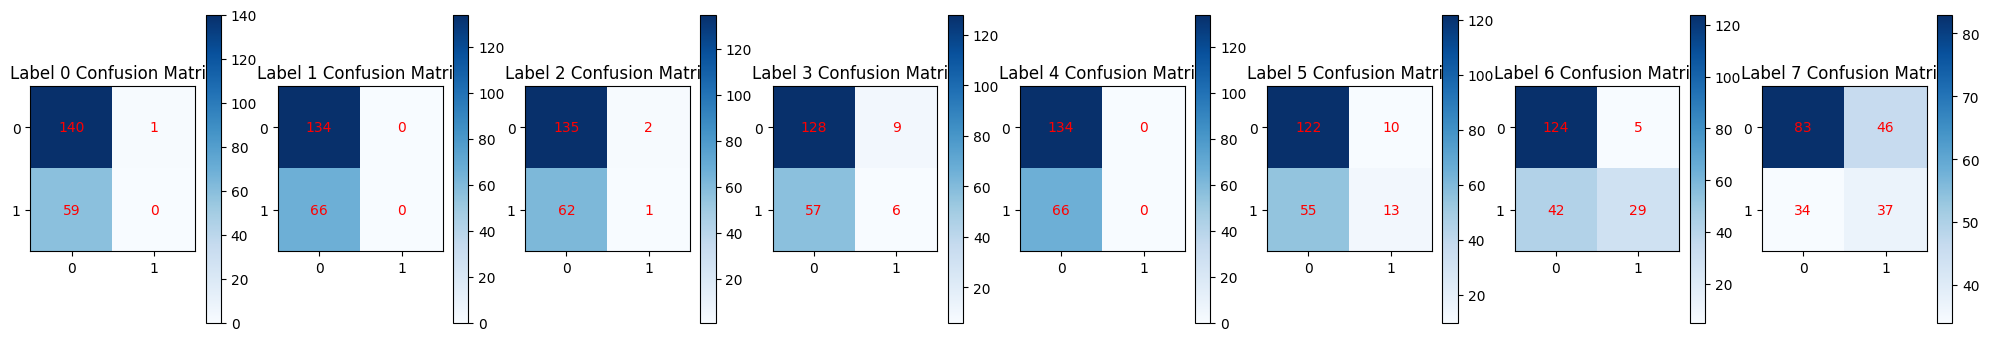

In [22]:
from sklearn.metrics import multilabel_confusion_matrix

confusion_matrix = multilabel_confusion_matrix(y_test, probabilities)
fig, axes = plt.subplots(1, len(confusion_matrix), figsize=(25, 4))
for i, label_confusion_matrix in enumerate(confusion_matrix):
    ax = axes[i]
    im = ax.imshow(label_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(2), yticks=np.arange(2), xticklabels=['0', '1'], yticklabels=['0', '1'], title=f'Label {i} Confusion Matrix')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(label_confusion_matrix[i, j]), ha="center", va="center", color="red")

plt.show()